In [180]:
import pandas as pd
import numpy as np 
import re 
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from pprint import pprint

# Using Wordnet for lemmatization
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [87]:
df = pd.read_csv("../beforecovid.csv")
df.head()

,Date,text,Year,Month,clean_text,join_clean_text,real_Date
0,25-Jan-19,"Mine is a 20 years resale flat, was top in 199...",19,Jan,"['mine', '20', 'years', 'resale', 'flat', 'top...",mine 20 years resale flat top 1999 got bomb sh...,2019-01-25
1,25-Jan-19,kimurayuki said:\r\nMine is a 20 years resale ...,19,Jan,"['kimurayuki', 'mine', '20', 'years', 'resale'...",kimurayuki mine 20 years resale flat top 1999 ...,2019-01-25
2,18-Jan-19,punggolbto said:\r\nAs per the actual HDB mode...,19,Jan,"['punggolbto', 'per', 'actual', 'hdb', 'models...",punggolbto per actual hdb models floor plans p...,2019-01-18
3,19-Oct-18,I have just purchased a resale flat recently w...,18,Oct,"['purchased', 'resale', 'flat', 'recently', 'w...",purchased resale flat recently without agent u...,2018-10-19
4,20-Oct-18,"Just to add, go to hdb website and check recen...",18,Oct,"['add', 'go', 'hdb', 'website', 'check', 'rece...",add go hdb website check recent 6mths resale t...,2018-10-20


In [88]:
df['clean_text'].head()

0    ['mine', '20', 'years', 'resale', 'flat', 'top...
1    ['kimurayuki', 'mine', '20', 'years', 'resale'...
2    ['punggolbto', 'per', 'actual', 'hdb', 'models...
3    ['purchased', 'resale', 'flat', 'recently', 'w...
4    ['add', 'go', 'hdb', 'website', 'check', 'rece...
Name: clean_text, dtype: object

In [89]:
len(df['clean_text'][0])

564

### Data Cleaning

In [90]:
# remove punc 
df['clean_text']  = df['join_clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))
# lower case
df['clean_text']  = df['clean_text'].apply(lambda x: x.lower())
# remove words with length < 2
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# tokenize
df['clean_text']  = [word_tokenize(row) for row in df['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ['u','m','lol','condo','said','also',"click","expand","http","www","com","https",'from', 'subject', 're', 'edu', 'use']
stop_words.extend(new_stop_words)

def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df['clean_text']  = df['clean_text'].apply(lambda x: remove_stopwords(x))

In [96]:
# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

df['clean_text'] = df['clean_text'].apply(lemmatize_text)

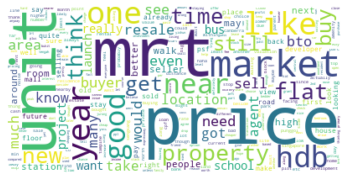

In [99]:
# Word Cloud

description_str = ''
for word_list in df['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '
    
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
# wordcloud.to_file("wordcloud_before_covid.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### LSA Topic Modelling

#### Prepare Corpus

In [133]:
# de-tokenization
detokenized_doc = df['clean_text'].tolist()

In [127]:
# Create Dictionary
id2word = corpora.Dictionary(detokenized_doc)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = detokenized_doc
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [128]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, '1999'), (1, 'aircon'), (2, 'bay'), (3, 'bomb'), (4, 'bought'), (5, 'buy'), (6, 'change'), (7, 'clearly'), (8, 'crazyclubx'), (9, 'door'), (10, 'end'), (11, 'external'), (12, 'flat'), (13, 'forever'), (14, 'got'), (15, 'haiz'), (16, 'hdb'), (17, 'hear'), (18, 'heard'), (19, 'home'), (20, 'house'), (21, 'inconsiderate'), (22, 'knew'), (23, 'last'), (24, 'least'), (25, 'ledge'), (26, 'loading'), (27, 'mine'), (28, 'move'), (29, 'neighbour'), (30, 'noise'), (31, 'noisy'), (32, 'pain'), (33, 'peace'), (34, 'punggol'), (35, 'rather'), (36, 'rent'), (37, 'resale'), (38, 'sell'), (39, 'shelter'), (40, 'slamming'), (41, 'stayed'), (42, 'supermarket'), (43, 'thought'), (44, 'time'), (45, 'top'), (46, 'traffic'), (47, 'unfortunately'), (48, 'upstairs'), (49, 'wait')]

Total Vocabulary Size: 14985


#### Hyperparameter Tuning

#### Helpers

In [215]:
def prepare_corpus(doc_clean):

    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model

    return dictionary, doc_term_matrix

In [216]:
def create_gensim_lsa_model(doc_clean, number_of_topics, words):

    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix = prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics = number_of_topics, num_words = words))

    return lsamodel

In [217]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):

    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics = number_of_topics, id2word = dictionary, chunksize = 100)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = doc_clean, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())
    
    return model_list, coherence_values

In [218]:
def plot_graph(doc_clean, start, stop, step):
    dictionary, doc_term_matrix = prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start prepare_corpus
end prepare_corpus
start compute_coherence_values
end compute_coherence_values


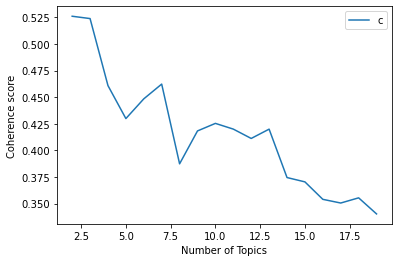

In [159]:
detokenized_doc = df['clean_text'].tolist()
start, stop, step = 2, 20, 1
plot_graph(detokenized_doc, start, stop, step)

### Building LSA Model 

In [229]:
number_of_topics = 7
words = 10
model = create_gensim_lsa_model(detokenized_doc, number_of_topics, words)

[(0, '0.336*"price" + 0.266*"unit" + 0.204*"year" + 0.194*"market" + 0.191*"mrt" + 0.157*"hdb" + 0.153*"like" + 0.150*"one" + 0.149*"flat" + 0.144*"property"'), (1, '0.481*"mrt" + -0.365*"price" + -0.256*"market" + 0.203*"bus" + -0.192*"property" + 0.184*"near" + -0.158*"buyer" + 0.157*"area" + 0.139*"station" + -0.133*"seller"'), (2, '-0.583*"unit" + 0.351*"flat" + 0.300*"hdb" + 0.265*"year" + -0.213*"price" + 0.157*"bto" + -0.115*"seller" + 0.106*"loan" + -0.103*"agent" + -0.101*"sold"'), (3, '-0.426*"unit" + -0.396*"flat" + -0.311*"hdb" + 0.298*"property" + -0.179*"seller" + 0.165*"market" + 0.155*"price" + -0.154*"agent" + -0.134*"resale" + -0.133*"room"'), (4, '-0.544*"price" + 0.383*"unit" + 0.290*"year" + 0.216*"property" + -0.198*"seller" + -0.180*"mrt" + 0.164*"rate" + -0.164*"buyer" + -0.119*"flat" + -0.106*"hdb"'), (5, '-0.332*"agent" + -0.329*"seller" + 0.272*"price" + 0.252*"flat" + -0.251*"buyer" + 0.166*"new" + 0.156*"resale" + 0.149*"unit" + 0.138*"year" + 0.137*"launch

In [230]:
pprint(model.print_topics())

[(0,
  '0.336*"price" + 0.266*"unit" + 0.204*"year" + 0.194*"market" + 0.191*"mrt" '
  '+ 0.157*"hdb" + 0.153*"like" + 0.150*"one" + 0.149*"flat" + '
  '0.144*"property"'),
 (1,
  '0.481*"mrt" + -0.365*"price" + -0.256*"market" + 0.203*"bus" + '
  '-0.192*"property" + 0.184*"near" + -0.158*"buyer" + 0.157*"area" + '
  '0.139*"station" + -0.133*"seller"'),
 (2,
  '-0.583*"unit" + 0.351*"flat" + 0.300*"hdb" + 0.265*"year" + -0.213*"price" '
  '+ 0.157*"bto" + -0.115*"seller" + 0.106*"loan" + -0.103*"agent" + '
  '-0.101*"sold"'),
 (3,
  '-0.426*"unit" + -0.396*"flat" + -0.311*"hdb" + 0.298*"property" + '
  '-0.179*"seller" + 0.165*"market" + 0.155*"price" + -0.154*"agent" + '
  '-0.134*"resale" + -0.133*"room"'),
 (4,
  '-0.544*"price" + 0.383*"unit" + 0.290*"year" + 0.216*"property" + '
  '-0.198*"seller" + -0.180*"mrt" + 0.164*"rate" + -0.164*"buyer" + '
  '-0.119*"flat" + -0.106*"hdb"'),
 (5,
  '-0.332*"agent" + -0.329*"seller" + 0.272*"price" + 0.252*"flat" + '
  '-0.251*"buyer" + 0.

In [231]:
coherence_model_lsa = CoherenceModel(model=model, texts=detokenized_doc, dictionary=id2word, coherence='c_v')
coherence_lsa = coherence_model_lsa.get_coherence()
print('Coherence Score: ', coherence_lsa)

Coherence Score:  0.45925110450365436
